# We explore using different search algorithms to solve Nonograms

This is the Nonogram we will be working on:

In [22]:
'''

Clue,[1],[3],[5],[3],[1]
[1],_,_,#,_,_
[3],_,#,#,#,_
[5],#,#,#,#,#
[3],_,#,#,#,_
[1],_,_,#,_,_

'''


'\n\nClue,[1],[3],[5],[3],[1]\n[1],_,_,#,_,_\n[3],_,#,#,#,_\n[5],#,#,#,#,#\n[3],_,#,#,#,_\n[1],_,_,#,_,_\n\n'

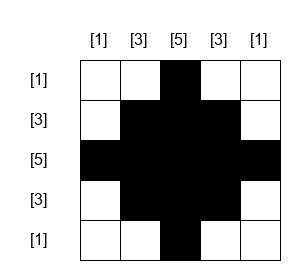

In [23]:
from IPython.display import Image, display

display(Image(filename="./4x4_nonogram_solution_output.png"))

Total nodes (including partial states): 69905
Total full board states (4x4 grid): 65536


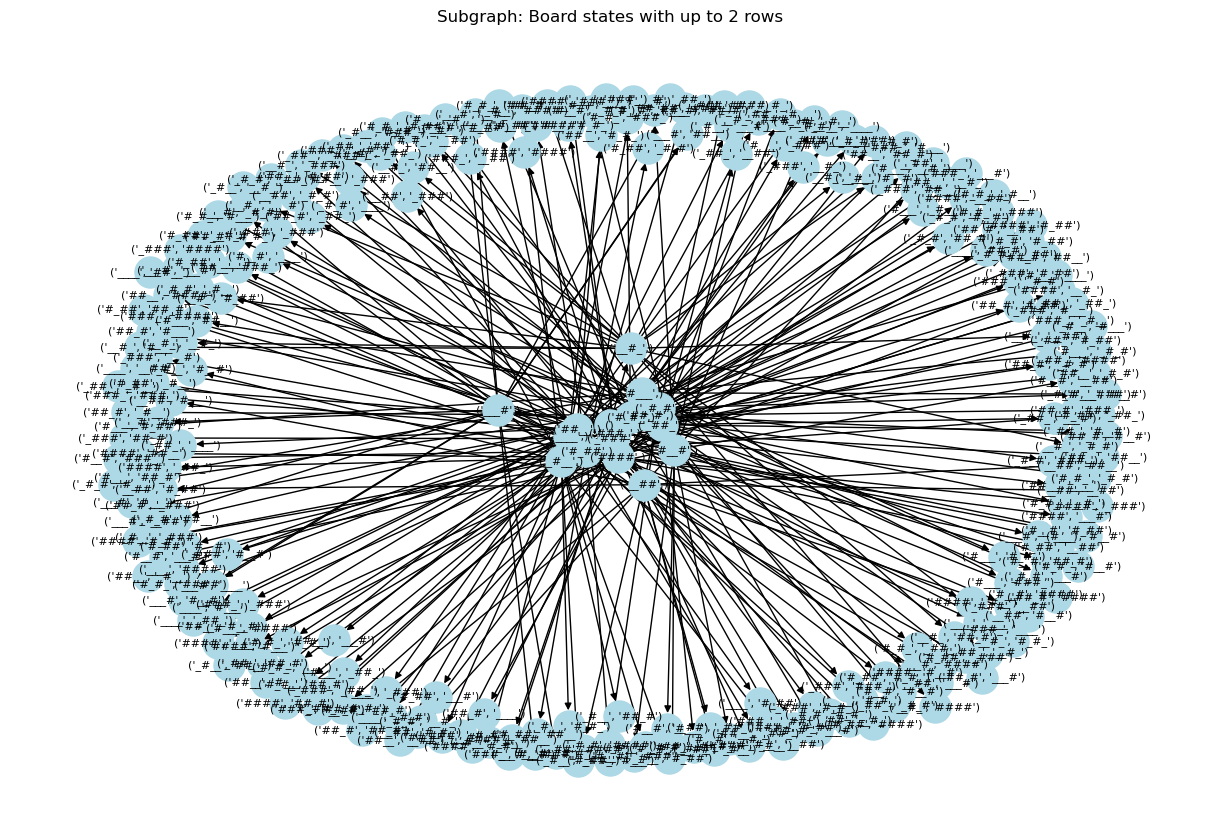

In [24]:
import networkx as nx
import matplotlib.pyplot as plt

def all_possible_rows():
    """
    Create all possible row configurations for a row of 4 cells.
    Each row is represented as a string, with '#' for a filled cell and '_' for a blank cell.
    There are 16 possible rows (2^4).
    """
    rows = []
    for i in range(16):
        row = "".join('#' if (i >> (3 - j)) & 1 else '_' for j in range(4))
        rows.append(row)
    return rows

def generate_graph_row_expansion():
    """
    Build a graph of board states by adding rows one by one.
    Each node is a tuple of strings (each string is one row).
    Starts from an empty board and appends one of the 16 possible rows until the board has 4 rows.
    """
    G = nx.DiGraph()
    initial_state = ()  # Empty board (no rows yet)
    G.add_node(initial_state)
    
    possible_rows = all_possible_rows()
    stack = [initial_state]
    
    while stack:
        current_state = stack.pop()
        if len(current_state) < 4:
            for row in possible_rows:
                new_state = current_state + (row,)
                if new_state not in G:
                    G.add_node(new_state)
                    G.add_edge(current_state, new_state)
                    if len(new_state) < 4:
                        stack.append(new_state)
                else:
                    if not G.has_edge(current_state, new_state):
                        G.add_edge(current_state, new_state)
    return G

# Build the complete game state graph.
G = generate_graph_row_expansion()

# Show some statistics.
total_nodes = len(G.nodes())
complete_boards = [node for node in G.nodes() if len(node) == 4]
print("Total nodes (including partial states):", total_nodes)
print("Total full board states (4x4 grid):", len(complete_boards))

# For visualisation, we show only a subgraph with nodes having up to 2 rows.
subgraph_nodes = [node for node in G.nodes() if len(node) <= 2]
H = G.subgraph(subgraph_nodes).copy()

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(H)
nx.draw(H, pos, with_labels=True, node_size=500, node_color="lightblue", arrows=True, font_size=8)
plt.title("Subgraph: Board states with up to 2 rows")
plt.show()


As we can see above, brute force searches will expand on all 2^16 gamestates of the Nonogram puzzle, which is infeasible.


In [25]:
from itertools import product
from collections import deque
import heapq

# -------------------------------
# Helper functions for Nonogram
# -------------------------------

def generate_row_combinations(row_clue, size):
    """Generate all possible ways to fill a row of given size that satisfy row_clue."""
    if row_clue == [0]:  # Special case: fully empty row
        return [['_'] * size]
    
    total_blocks = sum(row_clue)
    num_gaps = len(row_clue) - 1
    total_empty = size - total_blocks - num_gaps  # remaining empty spaces
    
    results = []

    def backtrack(idx, pos, row):
        if idx == len(row_clue):
            results.append(row[:])
            return
        block_size = row_clue[idx]
        for i in range(pos, size - block_size + 1):
            # Skip if any cell in the intended block is already filled
            if any(cell == '#' for cell in row[i:i+block_size]):
                continue
            # For subsequent blocks, ensure a gap (an empty cell) exists before starting
            if idx > 0 and row[i - 1] != '_':
                continue
            new_row = row[:]
            new_row[i:i + block_size] = ['#'] * block_size
            if i + block_size < size:
                new_row[i + block_size] = '_'
            backtrack(idx + 1, i + block_size + 1, new_row)
    row = ['_'] * size
    backtrack(0, 0, row)
    return results

def generate_all_row_combinations(row_clues, size):
    """Return a dictionary mapping each row index to its possible row combinations."""
    return {i: generate_row_combinations(clue, size) for i, clue in enumerate(row_clues)}

def extract_column_clues(grid):
    """Extract column clues from a full grid."""
    num_cols = len(grid[0])
    column_clues = []
    for col_idx in range(num_cols):
        col = [grid[row_idx][col_idx] for row_idx in range(len(grid))]
        clues = []
        count = 0
        for cell in col:
            if cell == '#':
                count += 1
            elif count > 0:
                clues.append(count)
                count = 0
        if count > 0:
            clues.append(count)
        column_clues.append(clues if clues else [0])
    return column_clues

def grid_matches_column_clues(grid, column_clues):
    """Check if the full grid matches the given column clues."""
    return extract_column_clues(grid) == column_clues

def is_partial_column_consistent(partial_col, clue):
    """
    Check if the partial column can still be extended to satisfy the full clue.
    Build the blocks from the partial column and ensure that they are a prefix of the clue
    and that no block is already longer than allowed.
    """
    blocks = []
    count = 0
    for cell in partial_col:
        if cell == '#':
            count += 1
        elif count > 0:
            blocks.append(count)
            count = 0
    if count > 0:
        blocks.append(count)
    for i, block in enumerate(blocks):
        if i >= len(clue) or block > clue[i]:
            return False
    return True

# -------------------------------
# Search Tree Node Class
# -------------------------------

class SearchTreeNode:
    def __init__(self, state, cost=0, parent=None):
        self.state = state            # The puzzle state: (row_index, grid)
        self.cost = cost              # Path cost to reach this node
        self.parent = parent          # Parent node in the search tree
        self.children = []            # List of child SearchTreeNode objects

# -------------------------------
# Problem formulation as a search problem
# -------------------------------

class NonogramPuzzle:
    def __init__(self, row_clues, column_clues, size):
        self.row_clues = row_clues
        self.column_clues = column_clues
        self.size = size
        # Pre-calculate the possible combinations for each row.
        self.row_options = generate_all_row_combinations(row_clues, size)
    
    @property
    def initial_state(self):
        # State is represented as a tuple: (current_row_index, assigned_rows).
        # Initially, no row has been assigned.
        return (0, [])
    
    def goal_test(self, state):
        row_idx, grid = state
        # A complete assignment is reached when row index equals size.
        # Then we check if the grid (all rows assigned) satisfies column clues.
        return row_idx == self.size and grid_matches_column_clues(grid, self.column_clues)
    
    def is_partial_consistent(self, grid):
        """
        For each column, check if the partial assignment (grid so far) can
        still be extended to satisfy the corresponding column clue.
        """
        for col in range(self.size):
            partial_col = [grid[row][col] for row in range(len(grid))]
            if not is_partial_column_consistent(partial_col, self.column_clues[col]):
                return False
        return True
    
    def successors(self, state):
        """
        Return a list of successor states.
        Each successor is generated by assigning one of the possible rows for the next row index.
        Only add successors if the resulting partial grid is consistent.
        """
        row_idx, grid = state
        if row_idx >= self.size:
            return []
        next_states = []
        for option in self.row_options[row_idx]:
            new_grid = grid + [option]
            if self.is_partial_consistent(new_grid):
                next_states.append((row_idx + 1, new_grid))
        return next_states
    
    def cost(self, state, action, next_state):
        # Each row assignment costs 1.
        return 1
    
    def heuristic(self, state):
        # A simple (admissible) heuristic: number of rows remaining.
        row_idx, _ = state
        return self.size - row_idx

# -------------------------------
# Recorded Search Algorithms (with Search Tree)
# -------------------------------

def recorded_breadth_first_search(problem):
    """BFS that records the search tree."""
    root = SearchTreeNode(problem.initial_state, cost=0)
    frontier = deque([root])
    states_explored = 0
    while frontier:
        node = frontier.popleft()
        states_explored += 1
        if problem.goal_test(node.state):
            return node, states_explored, root
        for succ in problem.successors(node.state):
            child = SearchTreeNode(succ, cost=node.cost + 1, parent=node)
            node.children.append(child)
            frontier.append(child)
    return None, states_explored, root

def recorded_depth_first_search(problem):
    """DFS that records the search tree."""
    root = SearchTreeNode(problem.initial_state, cost=0)
    frontier = [root]
    states_explored = 0
    while frontier:
        node = frontier.pop()
        states_explored += 1
        if problem.goal_test(node.state):
            return node, states_explored, root
        for succ in problem.successors(node.state):
            child = SearchTreeNode(succ, cost=node.cost + 1, parent=node)
            node.children.append(child)
            frontier.append(child)
    return None, states_explored, root

def recorded_uniform_cost_search(problem):
    """Uniform-Cost Search that records the search tree."""
    root = SearchTreeNode(problem.initial_state, cost=0)
    frontier = []
    counter = 0  # Tie-breaker counter
    heapq.heappush(frontier, (0, counter, root))
    states_explored = 0
    while frontier:
        cost, _, node = heapq.heappop(frontier)
        states_explored += 1
        if problem.goal_test(node.state):
            return node, states_explored, root
        for succ in problem.successors(node.state):
            child = SearchTreeNode(succ, cost=node.cost + 1, parent=node)
            node.children.append(child)
            counter += 1
            heapq.heappush(frontier, (child.cost, counter, child))
    return None, states_explored, root

def recorded_depth_limited_search(problem, limit):
    """Depth-Limited DFS that records the search tree."""
    states_explored = 0
    root = SearchTreeNode(problem.initial_state, cost=0)
    
    def recursive_dls(node, depth):
        nonlocal states_explored
        states_explored += 1
        if problem.goal_test(node.state):
            return node
        if depth == 0:
            return None
        for succ in problem.successors(node.state):
            child = SearchTreeNode(succ, cost=node.cost + 1, parent=node)
            node.children.append(child)
            result = recursive_dls(child, depth - 1)
            if result is not None:
                return result
        return None

    result = recursive_dls(root, limit)
    return result, states_explored, root

def recorded_iterative_deepening_search(problem):
    """Iterative Deepening DFS that records the search tree.
       (Returns the tree from the successful depth-limited search.)"""
    total_explored = 0
    limit = 0
    final_tree = None
    while True:
        # Reinitialize visited for each new depth limit
        result, explored, tree = recorded_depth_limited_search(problem, limit)
        total_explored += explored
        if result is not None:
            final_tree = tree
            return result, total_explored, final_tree
        limit += 1
        if limit > problem.size:  # safeguard in case no solution is found
            return None, total_explored, tree

def recorded_greedy_search(problem):
    """Greedy Search that records the search tree."""
    root = SearchTreeNode(problem.initial_state, cost=0)
    frontier = []
    counter = 0
    heapq.heappush(frontier, (problem.heuristic(root.state), counter, root))
    states_explored = 0
    while frontier:
        priority, _, node = heapq.heappop(frontier)
        states_explored += 1
        if problem.goal_test(node.state):
            return node, states_explored, root
        for succ in problem.successors(node.state):
            child = SearchTreeNode(succ, cost=node.cost + 1, parent=node)
            node.children.append(child)
            counter += 1
            heapq.heappush(frontier, (problem.heuristic(child.state), counter, child))
    return None, states_explored, root

def recorded_astar_search(problem):
    """A* Search that records the search tree."""
    root = SearchTreeNode(problem.initial_state, cost=0)
    frontier = []
    counter = 0
    f = root.cost + problem.heuristic(root.state)
    heapq.heappush(frontier, (f, root.cost, counter, root))
    states_explored = 0
    while frontier:
        f, g, _, node = heapq.heappop(frontier)
        states_explored += 1
        if problem.goal_test(node.state):
            return node, states_explored, root
        for succ in problem.successors(node.state):
            child = SearchTreeNode(succ, cost=node.cost + 1, parent=node)
            node.children.append(child)
            new_g = child.cost
            new_f = new_g + problem.heuristic(child.state)
            counter += 1
            heapq.heappush(frontier, (new_f, new_g, counter, child))
    return None, states_explored, root

# -------------------------------
# Function to print the search tree
# -------------------------------

def print_tree(node, indent=""):
    """
    Recursively print the search tree.
    For each node, display the row index, cost, and a compact representation of the grid.
    """
    row_idx, grid = node.state
    grid_str = "[" + ", ".join("".join(row) for row in grid) + "]"
    print(f"{indent}State(row_index={row_idx}, cost={node.cost}, grid={grid_str})")
    for child in node.children:
        print_tree(child, indent + "  ")

# -------------------------------
# Function to print the solution grid
# -------------------------------

def print_solution(state):
    """Prints the grid from a solution state."""
    if state is None:
        print("No solution found.")
        return
    row_idx, grid = state
    print("Solution Grid:")
    for row in grid:
        print(''.join(row))
    print()

# -------------------------------
# New Functions: Build Graph from Tree and Plot the Tree
# Each node's label is extended to show the current grid configuration.
# -------------------------------

def build_graph_from_tree(tree):
    import networkx as nx
    G = nx.DiGraph()
    counter = [0]  # mutable counter
    
    def add_node_recursive(t, parent=None):
        node_id = counter[0]
        counter[0] += 1
        row_idx, grid = t["state"]
        # Build a multi-line string of the current configuration
        grid_repr = "\n".join("".join(row) for row in grid) if grid else "<empty>"
        label = (f"ID:{node_id}\nRow:{row_idx}\nCost:{t['cost']}\n" +
                 f"{grid_repr}")
        G.add_node(node_id, label=label)
        if parent is not None:
            G.add_edge(parent, node_id)
        for child in t["children"]:
            add_node_recursive(child, parent=node_id)
    
    add_node_recursive(tree)
    return G

def plot_search_tree(tree):
    import networkx as nx
    import matplotlib.pyplot as plt
    G = build_graph_from_tree(tree)
    pos = nx.spring_layout(G, seed=42)
    labels = nx.get_node_attributes(G, "label")
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, labels=labels,
            node_size=2000, node_color="lightblue", arrows=True)
    plt.title("Search Tree")
    plt.show()
    
def generate_search_tree(node):
    """
    Converts a SearchTreeNode-based search tree into a dictionary format.
    Useful for graph building and plotting.
    """
    def recurse(n):
        return {
            "state": n.state,
            "cost": n.cost,
            "children": [recurse(child) for child in n.children]
        }
    return recurse(node)

# -------------------------------
# Main Execution: Setup Puzzle and Run Recorded Search Algorithms
# -------------------------------

# In this example the clues create a cross-like pattern for a 5x5 puzzle.
row_clues = [[1], [3], [5], [3], [1]]
column_clues = [[1], [3], [5], [3], [1]]
size = 5

# Create a Nonogram puzzle instance.
puzzle = NonogramPuzzle(row_clues, column_clues, size)

Nonogram Puzzle Recorded Search Results (with search trees) for a 5x5 Puzzle:

--- Breadth-First Search ---
States explored: 24
Solution Grid:
__#__
_###_
#####
_###_
__#__

Search Tree (text representation):
State(row_index=0, cost=0, grid=[])
  State(row_index=1, cost=1, grid=[#____])
    State(row_index=2, cost=2, grid=[#____, _###_])
    State(row_index=2, cost=2, grid=[#____, __###])
  State(row_index=1, cost=1, grid=[_#___])
    State(row_index=2, cost=2, grid=[_#___, ###__])
    State(row_index=2, cost=2, grid=[_#___, _###_])
      State(row_index=3, cost=3, grid=[_#___, _###_, #####])
    State(row_index=2, cost=2, grid=[_#___, __###])
  State(row_index=1, cost=1, grid=[__#__])
    State(row_index=2, cost=2, grid=[__#__, ###__])
    State(row_index=2, cost=2, grid=[__#__, _###_])
      State(row_index=3, cost=3, grid=[__#__, _###_, #####])
        State(row_index=4, cost=4, grid=[__#__, _###_, #####, _###_])
          State(row_index=5, cost=5, grid=[__#__, _###_, #####, _###_,

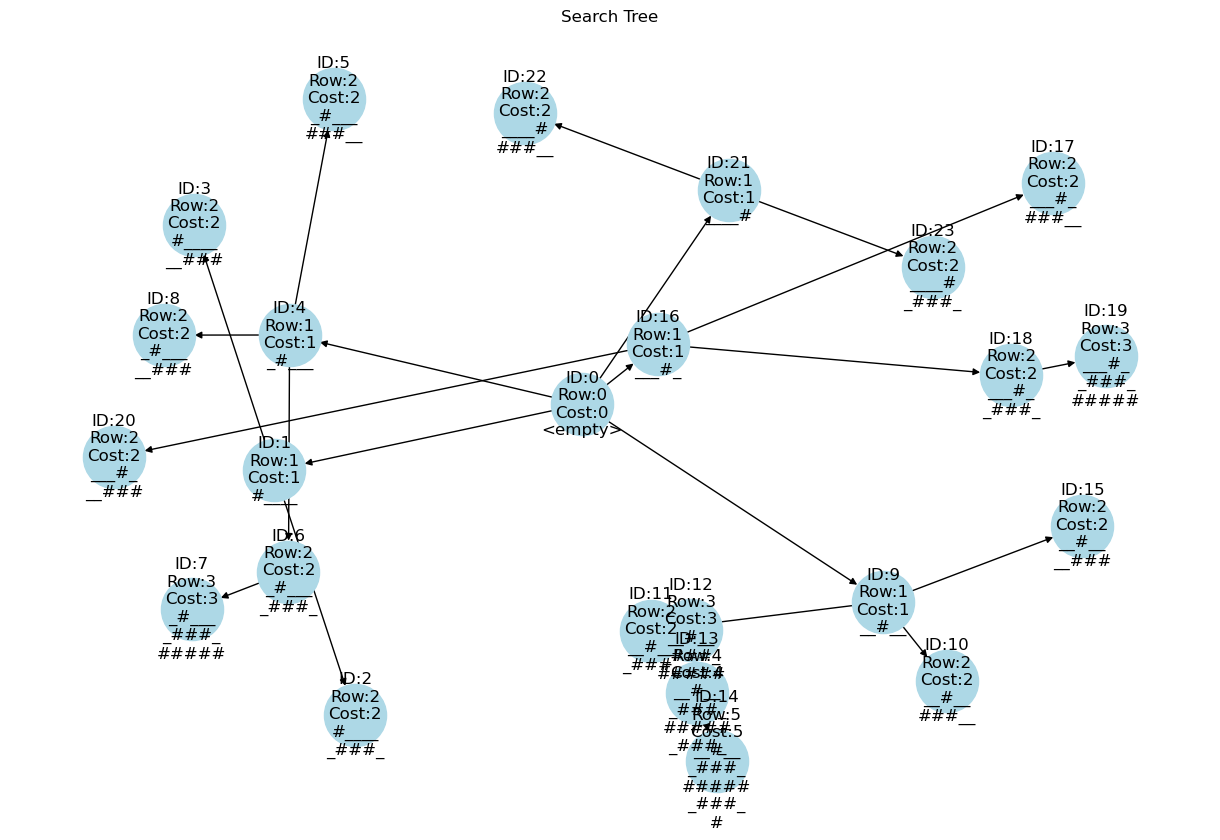



--- Depth-First Search ---
States explored: 15
Solution Grid:
__#__
_###_
#####
_###_
__#__

Search Tree (text representation):
State(row_index=0, cost=0, grid=[])
  State(row_index=1, cost=1, grid=[#____])
  State(row_index=1, cost=1, grid=[_#___])
  State(row_index=1, cost=1, grid=[__#__])
    State(row_index=2, cost=2, grid=[__#__, ###__])
    State(row_index=2, cost=2, grid=[__#__, _###_])
      State(row_index=3, cost=3, grid=[__#__, _###_, #####])
        State(row_index=4, cost=4, grid=[__#__, _###_, #####, _###_])
          State(row_index=5, cost=5, grid=[__#__, _###_, #####, _###_, __#__])
    State(row_index=2, cost=2, grid=[__#__, __###])
  State(row_index=1, cost=1, grid=[___#_])
    State(row_index=2, cost=2, grid=[___#_, ###__])
    State(row_index=2, cost=2, grid=[___#_, _###_])
      State(row_index=3, cost=3, grid=[___#_, _###_, #####])
    State(row_index=2, cost=2, grid=[___#_, __###])
  State(row_index=1, cost=1, grid=[____#])
    State(row_index=2, cost=2, grid=

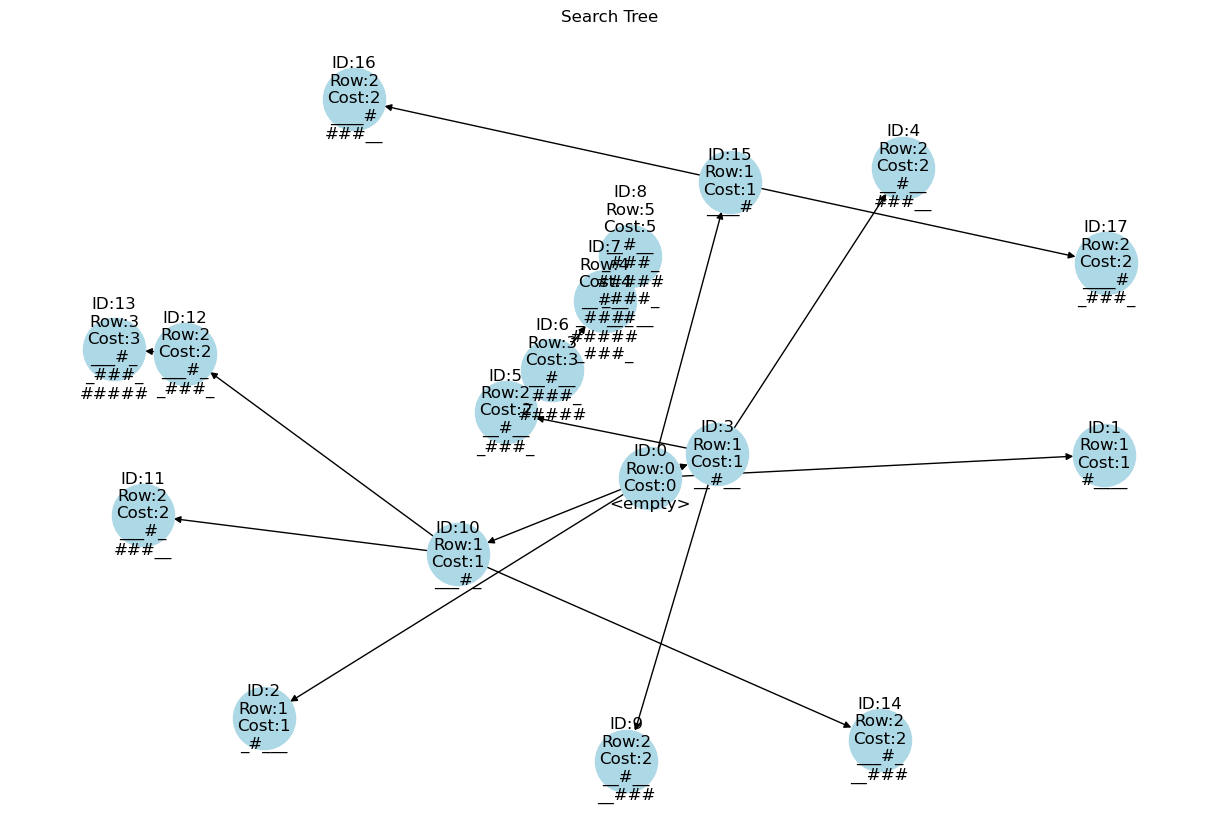



--- Uniform-Cost Search ---
States explored: 24
Solution Grid:
__#__
_###_
#####
_###_
__#__

Search Tree (text representation):
State(row_index=0, cost=0, grid=[])
  State(row_index=1, cost=1, grid=[#____])
    State(row_index=2, cost=2, grid=[#____, _###_])
    State(row_index=2, cost=2, grid=[#____, __###])
  State(row_index=1, cost=1, grid=[_#___])
    State(row_index=2, cost=2, grid=[_#___, ###__])
    State(row_index=2, cost=2, grid=[_#___, _###_])
      State(row_index=3, cost=3, grid=[_#___, _###_, #####])
    State(row_index=2, cost=2, grid=[_#___, __###])
  State(row_index=1, cost=1, grid=[__#__])
    State(row_index=2, cost=2, grid=[__#__, ###__])
    State(row_index=2, cost=2, grid=[__#__, _###_])
      State(row_index=3, cost=3, grid=[__#__, _###_, #####])
        State(row_index=4, cost=4, grid=[__#__, _###_, #####, _###_])
          State(row_index=5, cost=5, grid=[__#__, _###_, #####, _###_, __#__])
    State(row_index=2, cost=2, grid=[__#__, __###])
  State(row_index

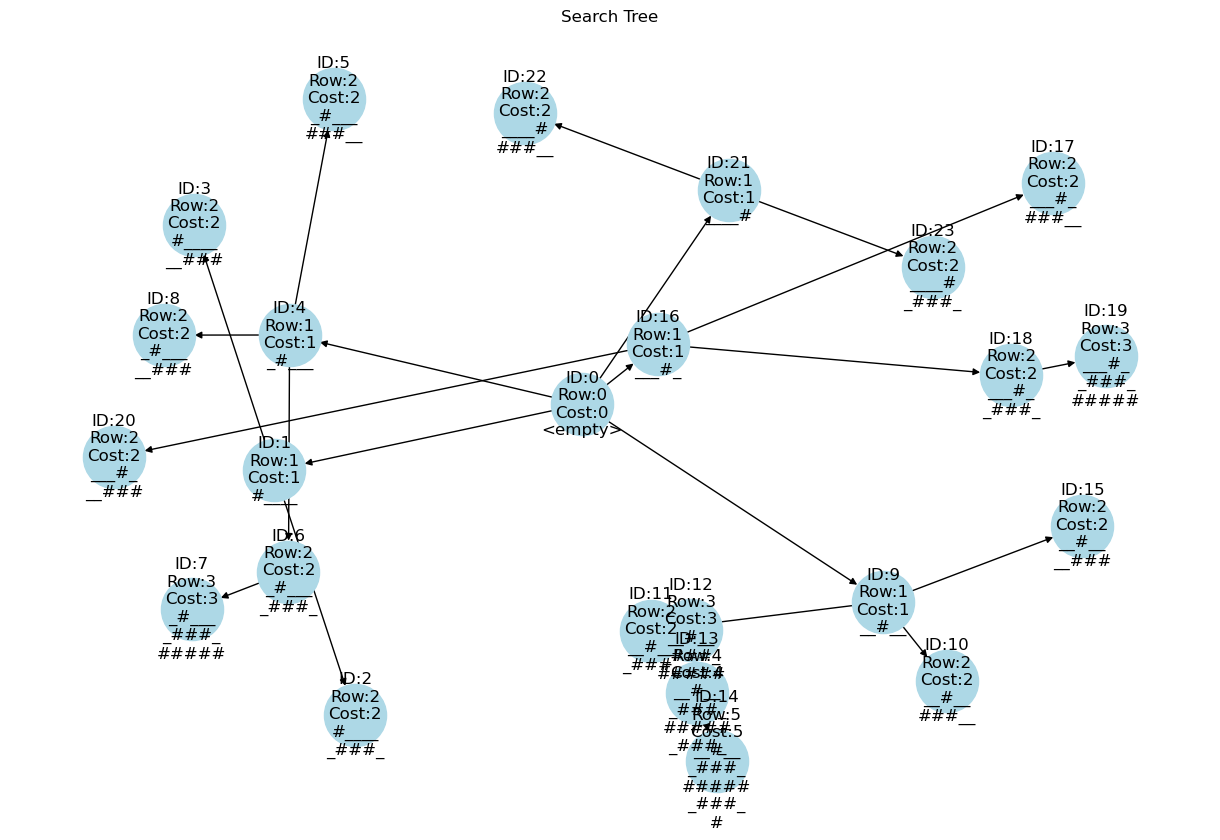



--- Depth-Limited DFS (limit=size) ---
States explored: 15
Solution Grid:
__#__
_###_
#####
_###_
__#__

Search Tree (text representation):
State(row_index=0, cost=0, grid=[])
  State(row_index=1, cost=1, grid=[#____])
    State(row_index=2, cost=2, grid=[#____, _###_])
    State(row_index=2, cost=2, grid=[#____, __###])
  State(row_index=1, cost=1, grid=[_#___])
    State(row_index=2, cost=2, grid=[_#___, ###__])
    State(row_index=2, cost=2, grid=[_#___, _###_])
      State(row_index=3, cost=3, grid=[_#___, _###_, #####])
    State(row_index=2, cost=2, grid=[_#___, __###])
  State(row_index=1, cost=1, grid=[__#__])
    State(row_index=2, cost=2, grid=[__#__, ###__])
    State(row_index=2, cost=2, grid=[__#__, _###_])
      State(row_index=3, cost=3, grid=[__#__, _###_, #####])
        State(row_index=4, cost=4, grid=[__#__, _###_, #####, _###_])
          State(row_index=5, cost=5, grid=[__#__, _###_, #####, _###_, __#__])


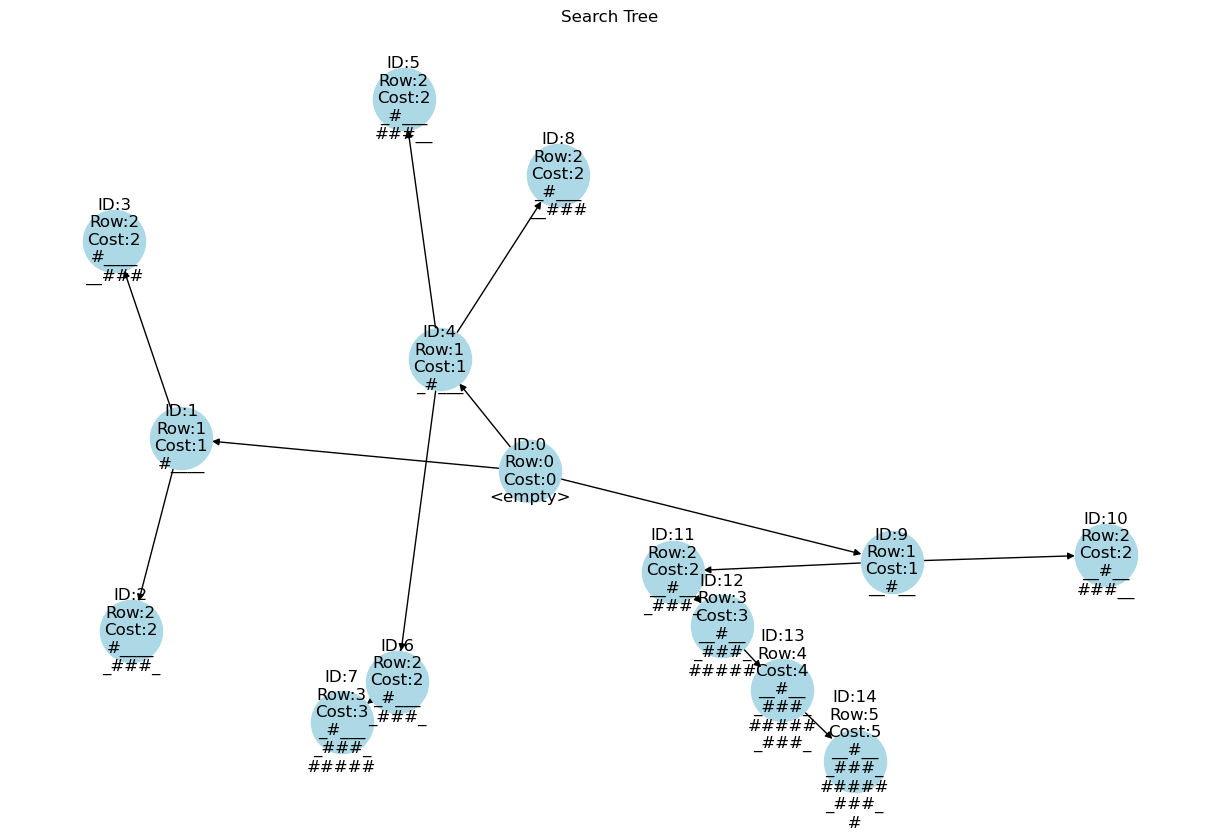



--- Iterative Deepening DFS ---
States explored: 86
Solution Grid:
__#__
_###_
#####
_###_
__#__

Search Tree (text representation):
State(row_index=0, cost=0, grid=[])
  State(row_index=1, cost=1, grid=[#____])
    State(row_index=2, cost=2, grid=[#____, _###_])
    State(row_index=2, cost=2, grid=[#____, __###])
  State(row_index=1, cost=1, grid=[_#___])
    State(row_index=2, cost=2, grid=[_#___, ###__])
    State(row_index=2, cost=2, grid=[_#___, _###_])
      State(row_index=3, cost=3, grid=[_#___, _###_, #####])
    State(row_index=2, cost=2, grid=[_#___, __###])
  State(row_index=1, cost=1, grid=[__#__])
    State(row_index=2, cost=2, grid=[__#__, ###__])
    State(row_index=2, cost=2, grid=[__#__, _###_])
      State(row_index=3, cost=3, grid=[__#__, _###_, #####])
        State(row_index=4, cost=4, grid=[__#__, _###_, #####, _###_])
          State(row_index=5, cost=5, grid=[__#__, _###_, #####, _###_, __#__])


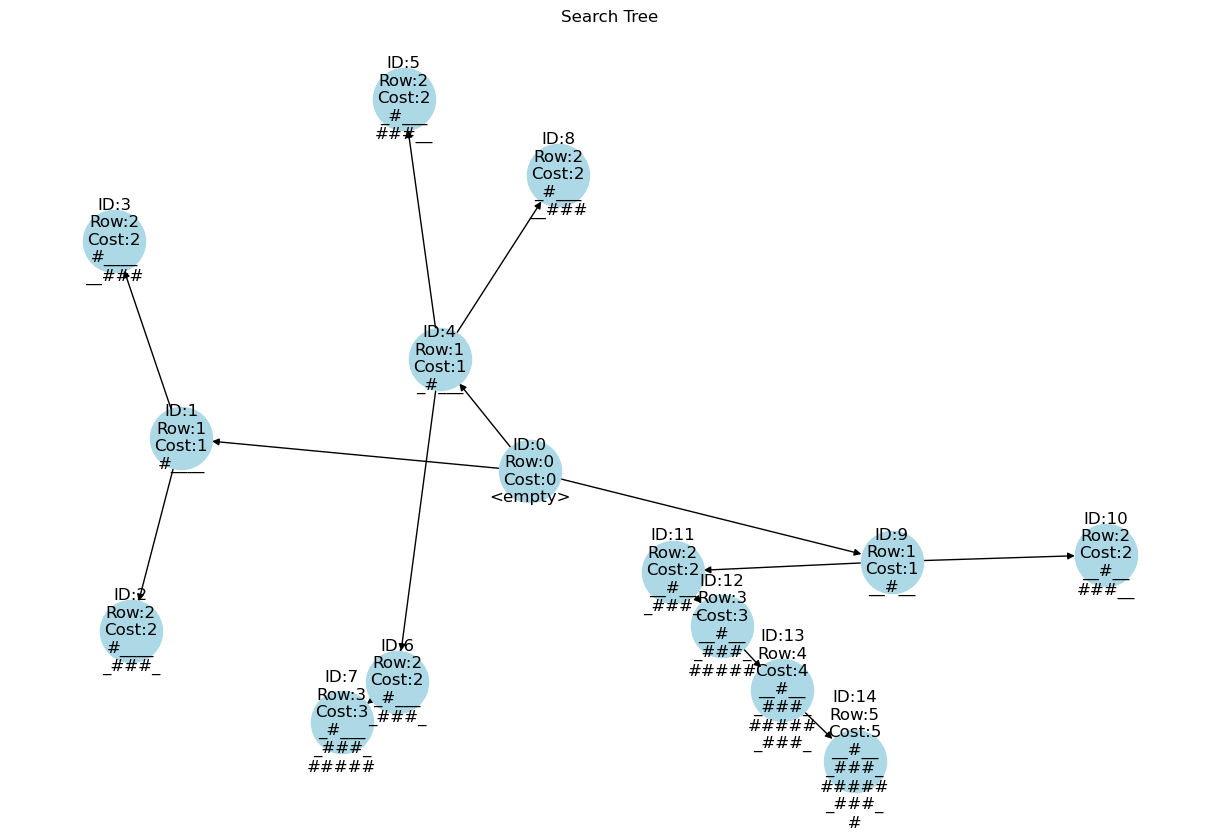



--- Greedy Search ---
States explored: 15
Solution Grid:
__#__
_###_
#####
_###_
__#__

Search Tree (text representation):
State(row_index=0, cost=0, grid=[])
  State(row_index=1, cost=1, grid=[#____])
    State(row_index=2, cost=2, grid=[#____, _###_])
    State(row_index=2, cost=2, grid=[#____, __###])
  State(row_index=1, cost=1, grid=[_#___])
    State(row_index=2, cost=2, grid=[_#___, ###__])
    State(row_index=2, cost=2, grid=[_#___, _###_])
      State(row_index=3, cost=3, grid=[_#___, _###_, #####])
    State(row_index=2, cost=2, grid=[_#___, __###])
  State(row_index=1, cost=1, grid=[__#__])
    State(row_index=2, cost=2, grid=[__#__, ###__])
    State(row_index=2, cost=2, grid=[__#__, _###_])
      State(row_index=3, cost=3, grid=[__#__, _###_, #####])
        State(row_index=4, cost=4, grid=[__#__, _###_, #####, _###_])
          State(row_index=5, cost=5, grid=[__#__, _###_, #####, _###_, __#__])
    State(row_index=2, cost=2, grid=[__#__, __###])
  State(row_index=1, co

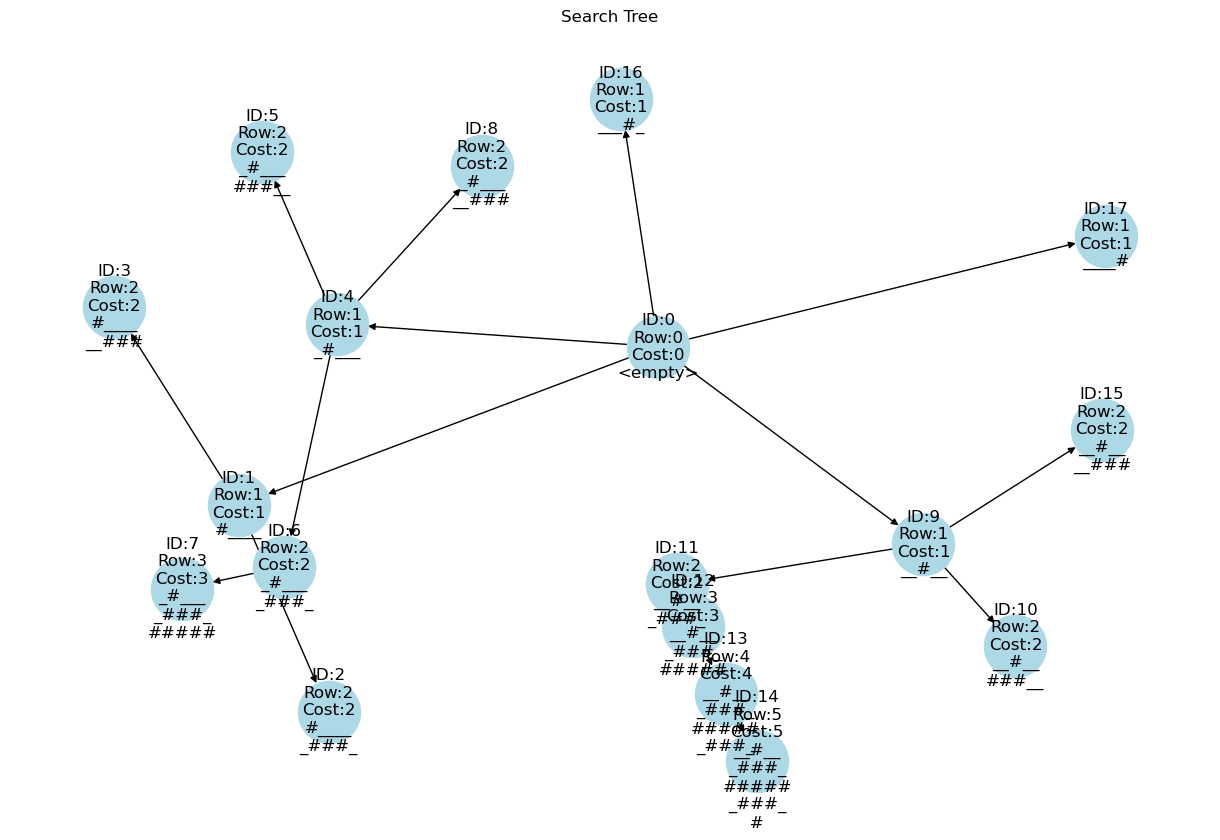



--- A* Search ---
States explored: 24
Solution Grid:
__#__
_###_
#####
_###_
__#__

Search Tree (text representation):
State(row_index=0, cost=0, grid=[])
  State(row_index=1, cost=1, grid=[#____])
    State(row_index=2, cost=2, grid=[#____, _###_])
    State(row_index=2, cost=2, grid=[#____, __###])
  State(row_index=1, cost=1, grid=[_#___])
    State(row_index=2, cost=2, grid=[_#___, ###__])
    State(row_index=2, cost=2, grid=[_#___, _###_])
      State(row_index=3, cost=3, grid=[_#___, _###_, #####])
    State(row_index=2, cost=2, grid=[_#___, __###])
  State(row_index=1, cost=1, grid=[__#__])
    State(row_index=2, cost=2, grid=[__#__, ###__])
    State(row_index=2, cost=2, grid=[__#__, _###_])
      State(row_index=3, cost=3, grid=[__#__, _###_, #####])
        State(row_index=4, cost=4, grid=[__#__, _###_, #####, _###_])
          State(row_index=5, cost=5, grid=[__#__, _###_, #####, _###_, __#__])
    State(row_index=2, cost=2, grid=[__#__, __###])
  State(row_index=1, cost=1

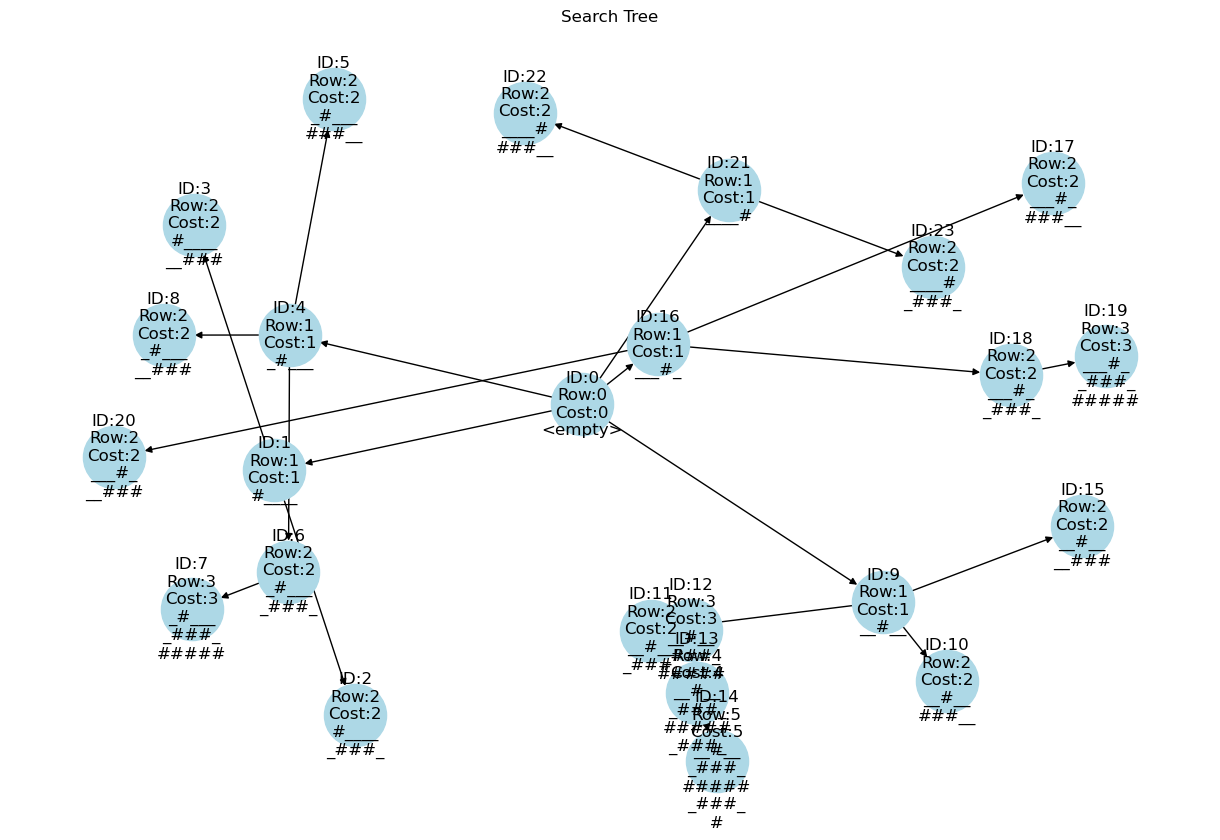

In [26]:
# List of recorded search methods to apply.
recorded_search_algorithms = [
    ("Breadth-First Search", recorded_breadth_first_search),
    ("Depth-First Search", recorded_depth_first_search),
    ("Uniform-Cost Search", recorded_uniform_cost_search),
    ("Depth-Limited DFS (limit=size)", lambda prob: recorded_depth_limited_search(prob, prob.size)),
    ("Iterative Deepening DFS", recorded_iterative_deepening_search),
    ("Greedy Search", recorded_greedy_search),
    ("A* Search", recorded_astar_search)
]

print("Nonogram Puzzle Recorded Search Results (with search trees) for a 5x5 Puzzle:\n")
for name, algorithm in recorded_search_algorithms:
    solution_node, explored, tree_root = algorithm(puzzle)
    print(f"--- {name} ---")
    print(f"States explored: {explored}")
    print_solution(solution_node.state if solution_node else None)
    print("Search Tree (text representation):")
    print_tree(tree_root)
    # Generate dictionary representation and plot the search tree
    tree_dict = generate_search_tree(tree_root)
    plot_search_tree(tree_dict)
    print("\n" + "="*60 + "\n")